In [3]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from fucntions import data_seq,train_seq

In [4]:
"""
!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git
%cd QHackathon_2024/
!pip install -r requirements.txt"""

'\n!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git\n%cd QHackathon_2024/\n!pip install -r requirements.txt'

In [5]:

n_qu = 4
dev = qml.device('default.qubit', wires=2*n_qu)

def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(2*n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(2*n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([2*n_qu - 1, 0])

def embedding(params, n_qu, is_first):
    for i in range(n_qu):
        qml.Hadamard(wires=i if is_first else i+n_qu)
        qml.RZ(2.0*params[:,i], wires=i if is_first else i+n_qu)

    for i in range(n_qu-1):
        qml.IsingZZ(2.0*params[:, i] ,wires = [i if is_first else i+n_qu, i+1 if is_first else i+n_qu+1])

@qml.qnode(device=dev, interface='torch')
def quantum_layer(mapped_data1, mapped_data2, parameter, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu, is_first=True)
    embedding(params=mapped_data2, n_qu=n_qu, is_first=False)
    qml.Barrier()
    ansatz(params=parameter, n_qu = n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu)]

(<Figure size 1900x900 with 1 Axes>, <Axes: >)

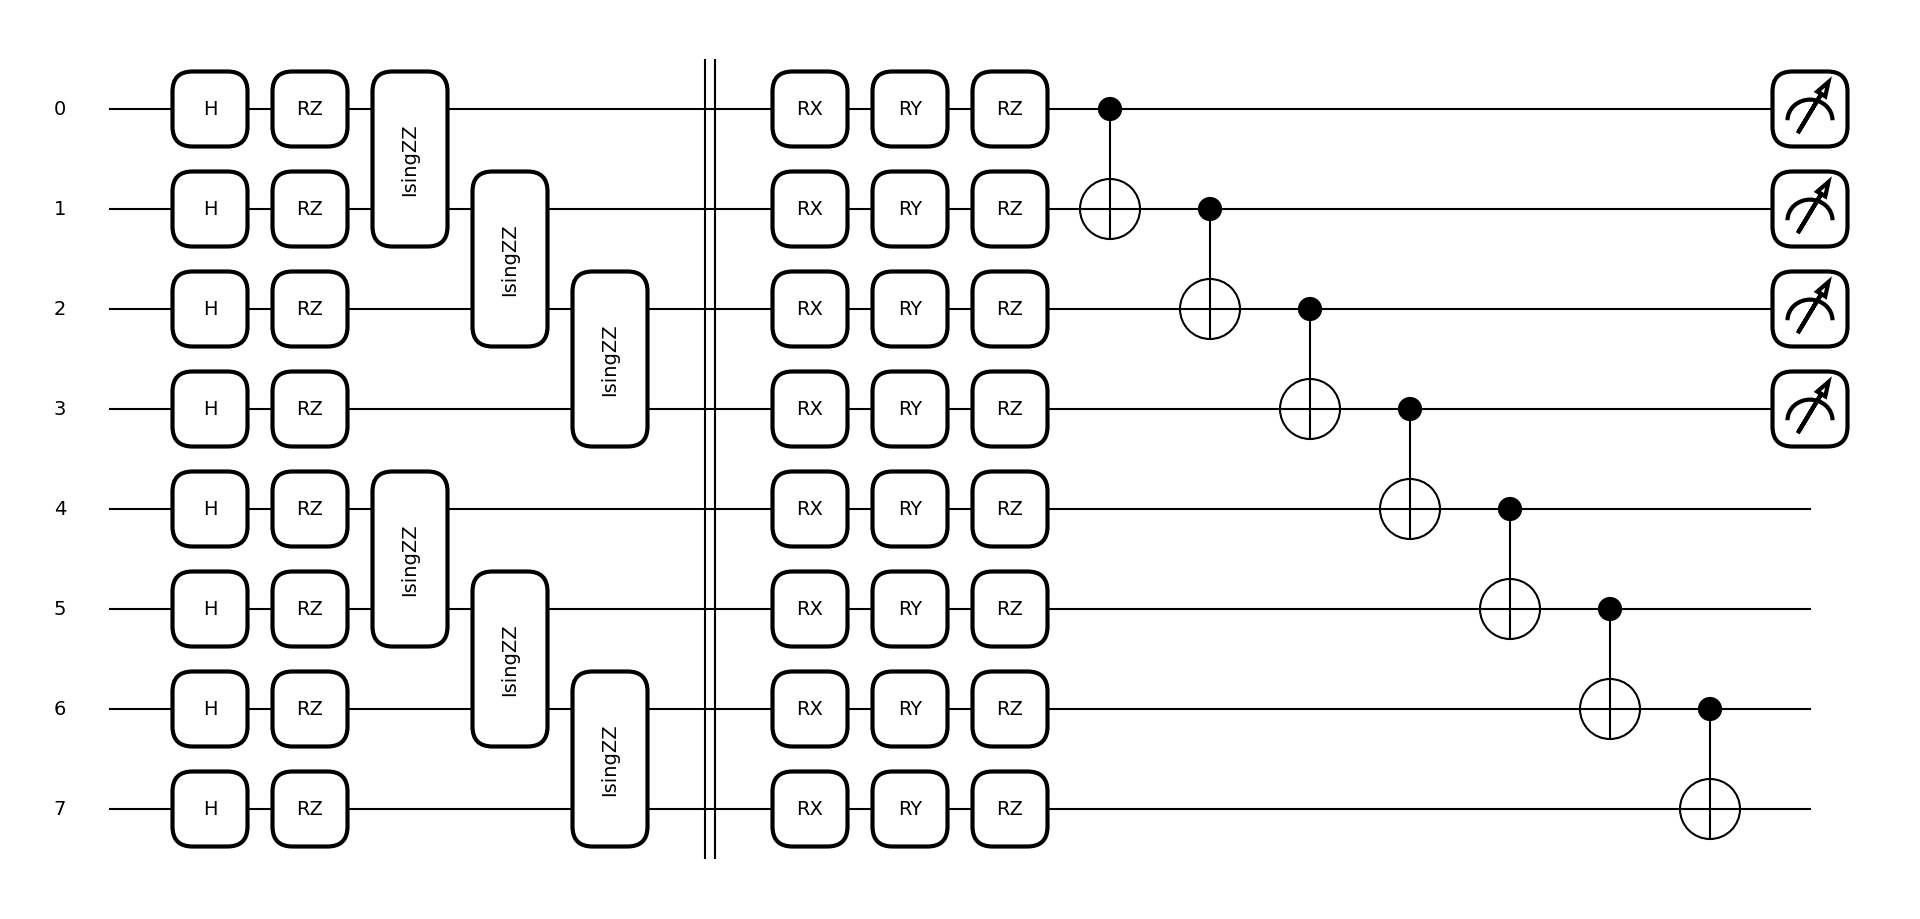

In [6]:
qml.draw_mpl(quantum_layer)(torch.rand(1,2*n_qu-1), torch.rand(1,2*n_qu-1), torch.rand(1,6*n_qu), n_qu=n_qu)

In [7]:
class QGRU(nn.Module):
    def __init__(self, n_qu):
        self.n_qu = n_qu
        super(QGRU, self).__init__()
        for i in range(3):
            setattr(self,f'ql{i}', quantum_layer)

        self.cls_layer = nn.Sequential(nn.Linear(n_qu,8),nn.ReLU(),nn.Linear(8,1)).to(torch.float32)

        self.ansatz_params_1 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_3 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)

    def nQE_layer(self, input):
        n_qu = input.shape[1]
        n_batch = input.shape[0]
        for i in range(n_qu-1):
            input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
        return input

    def forward(self, inputs, return_hidden_list = False):
        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        n_qu = inputs.shape[2]
        inputs = inputs.permute(1,0,2)
        h0 = torch.zeros(batch,n_qu)
        input0 = self.nQE_layer(inputs[0])
        r0 = torch.stack(self.ql0(input0, self.nQE_layer(h0), self.ansatz_params_1, n_qu),dim=1)
        r0 = nn.Sigmoid()(r0)
        z0 = torch.stack(self.ql1(input0, self.nQE_layer(h0), self.ansatz_params_2, n_qu),dim=1)
        z0 = nn.Sigmoid()(z0)
        n0 = torch.stack(self.ql2(input0, r0, self.ansatz_params_3, n_qu),dim=1)
        n0 = nn.Tanh()(n0)
        hidden = (1-z0)*n0+z0*h0
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.nQE_layer(input)
            h = hidden
            ah = self.nQE_layer(hidden)
            r = torch.stack(self.ql0(input, ah, self.ansatz_params_1, n_qu),dim=1)
            r = nn.Sigmoid()(r)
            z = torch.stack(self.ql1(input, ah, self.ansatz_params_2, n_qu),dim=1)
            z = nn.Sigmoid()(z)
            n = torch.stack(self.ql2(input, r, self.ansatz_params_3, n_qu),dim=1)
            n = nn.Tanh()(n)
            hidden = (1-z)*n+z*h
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list, hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch, seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden.to(torch.float32))

In [29]:
import pandas as pd

n_train = 50
df = pd.read_csv('./dataset.csv')
print(df.keys())

Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')


In [40]:
y_train = torch.tensor(df['nat_demand'].to_numpy()[[10+10*i for i in range(25)]])
y_train = torch.unsqueeze(y_train,dim=1)
print(y_train.shape)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:250]).to(torch.float)
print(x_train.shape)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(-1,10,4)
print(xs.shape)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


torch.Size([25, 1])
torch.Size([250, 12])
torch.Size([25, 10, 4])


In [35]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0),self.hidden_size)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 사용
        return out

In [36]:
import torch.optim as optim
#model = QGRU(4).to(torch.float32)
model = RNNModel(4,32,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [37]:
data_corpus = data_seq(xs.float(),y_train.float())
train_loader,test_loader = data_corpus.split_data()
train_corpus = train_seq(model,train_loader,test_loader)

In [38]:
train_corpus.train(1000,optimizer,criterion)

epoch : 1 loss :1143224.75 loss_test = 1608489.375
epoch : 2 loss :1136915.125 loss_test = 1603044.75
epoch : 3 loss :1132345.375 loss_test = 1597381.375
epoch : 4 loss :1127599.875 loss_test = 1591376.375
epoch : 5 loss :1122570.5 loss_test = 1584797.25
epoch : 6 loss :1117062.5 loss_test = 1577854.5
epoch : 7 loss :1111252.75 loss_test = 1570667.5
epoch : 8 loss :1105241.25 loss_test = 1563309.25
epoch : 9 loss :1099089.25 loss_test = 1555827.75
epoch : 10 loss :1092837.25 loss_test = 1548256.25
epoch : 11 loss :1086513.125 loss_test = 1540618.25
epoch : 12 loss :1080136.625 loss_test = 1532932.0
epoch : 13 loss :1073723.125 loss_test = 1525211.25
epoch : 14 loss :1067284.0 loss_test = 1517466.625
epoch : 15 loss :1060828.5 loss_test = 1509707.0
epoch : 16 loss :1054363.625 loss_test = 1501939.0
epoch : 17 loss :1047895.3125 loss_test = 1494168.75
epoch : 18 loss :1041428.5 loss_test = 1486400.625
epoch : 19 loss :1034967.0 loss_test = 1478638.75
epoch : 20 loss :1028514.1875 loss_te

In [39]:
for feature,label in test_loader:
    print(feature)
    print(model(feature),label)
    break

tensor([[[1.6113e-02, 2.3996e+01, 7.0648e-02, 1.6009e+01],
         [1.6301e-02, 2.5032e+01, 6.0473e-02, 1.8388e+01],
         [1.6330e-02, 2.6144e+01, 5.4067e-02, 2.0201e+01],
         [1.6332e-02, 2.7102e+01, 4.6070e-02, 2.0491e+01],
         [1.6397e-02, 2.7831e+01, 3.8696e-02, 1.9899e+01],
         [1.6487e-02, 2.8352e+01, 2.9830e-02, 1.9069e+01],
         [1.6547e-02, 2.8651e+01, 2.7876e-02, 1.8208e+01],
         [1.6562e-02, 2.8595e+01, 2.7367e-02, 1.7578e+01],
         [1.6507e-02, 2.8185e+01, 2.8879e-02, 1.7221e+01],
         [1.6402e-02, 2.7419e+01, 3.0187e-02, 1.6821e+01]],

        [[1.6981e-02, 2.3738e+01, 4.1508e-02, 1.3449e+01],
         [1.6985e-02, 2.3761e+01, 4.3316e-02, 1.3729e+01],
         [1.7006e-02, 2.3786e+01, 4.3485e-02, 1.3829e+01],
         [1.7044e-02, 2.3845e+01, 4.6075e-02, 1.3994e+01],
         [1.7293e-02, 2.4545e+01, 4.8504e-02, 1.5594e+01],
         [1.7464e-02, 2.5774e+01, 4.9706e-02, 1.7992e+01],
         [1.7419e-02, 2.6961e+01, 4.6571e-02, 1.9394e+

In [ ]:
y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float).reshape(1,50,1)
print(y_train.shape)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)
print(x_train.shape)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(1,50,4)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


import torch.optim as optim
# Define the training loop



def train_layer(inputs,targets,model):
    # Parameters
    num_epochs = 500
    learning_rate = 0.2


    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Dummy data for training

    # Training loop
    for epoch in range(num_epochs):

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(torch.float32)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([1, 50, 1])
torch.Size([50, 12])


In [ ]:
model = QGRU(4).to(torch.float32)

In [ ]:
train_layer(xs.to(torch.float32), y_train.to(torch.float32), model)

/Users/jeon-yuseong/miniconda3/envs/penny_torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 50, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Loss: 1076137.3750
Epoch [2/500], Loss: 1075223.2500
Epoch [3/500], Loss: 1074069.7500
Epoch [4/500], Loss: 1072090.7500
Epoch [5/500], Loss: 1068951.2500
Epoch [6/500], Loss: 1064471.5000
Epoch [7/500], Loss: 1058890.5000
Epoch [8/500], Loss: 1053203.7500
Epoch [9/500], Loss: 1045896.8125
Epoch [10/500], Loss: 1037101.2500
Epoch [11/500], Loss: 1027466.5000
Epoch [12/500], Loss: 1016006.6250
Epoch [13/500], Loss: 1002249.1250
Epoch [14/500], Loss: 986216.0000
Epoch [15/500], Loss: 968299.8125
Epoch [16/500], Loss: 948492.0000
Epoch [17/500], Loss: 928357.6875
Epoch [18/500], Loss: 907706.5000
Epoch [19/500], Loss: 885891.9375
Epoch [20/500], Loss: 862132.6250
Epoch [21/500], Loss: 836294.3750
Epoch [22/500], Loss: 808483.5000
Epoch [23/500], Loss: 779296.9375
Epoch [24/500], Loss: 749222.0625
Epoch [25/500], Loss: 718772.8125
Epoch [26/500], Loss: 687639.1875
Epoch [27/500], Loss: 654609.3750
Epoch [28/500], Loss: 620000.3750
Epoch [29/500], Loss: 584305.6250
Epoch [30/

KeyboardInterrupt: 